# Detection dataset

This notebook uses the model output of clustering.ipynb to create a labeled dataset of cells and noise

### Imports

In [3]:
import os
import cv2
import keras
import joblib
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import os
from tqdm.contrib.concurrent import process_map
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16, VGG19, ResNet50, InceptionV3, DenseNet121, MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras.models import Model
import shutil

import sys
sys.path.insert(0, "../../packages/python")
from data import utils as data_utils

### Definitions

In [ ]:
sys.path.insert(0, "../../")
from config import MEDIA_PATH, CROPPED_PATH, MODELS_PATH

# Configuration
INPUT_SHAPE = (128, 128, 3)
MODEL = 'clustering_VGG16_kmeans_v0'
BASE_MODEL = MODEL.split('_')[1]
METHOD = MODEL.split('_')[2]

# Paths
CROPPED_PATH = os.path.join(CROPPED_PATH, 'ina', 'images')
MODEL_PATH = os.path.join(MODELS_PATH, f'{MODEL}.pkl')
OUTPUT_PATH = os.path.join(MEDIA_PATH, 'cropped_images', 'ina', 'labeled_images', f"{BASE_MODEL}_{METHOD}_v0")

### Functions

In [5]:
def load_image (x):
    if BASE_MODEL == "AutoEncoder":
        return cv2.imread(x, cv2.IMREAD_GRAYSCALE)
    else:
        return cv2.imread(x)

#### Get cluster representatrives

In [6]:
CROPPED_PATHs = sorted(data_utils.get_relative_file_paths(CROPPED_PATH))

images = process_map(
                load_image,
                CROPPED_PATHs,
                total=len(CROPPED_PATHs),
                max_workers=16,
                chunksize=32,
            )

resized_images = [cv2.resize(image, INPUT_SHAPE[0:2]) for image in images]
resized_images = np.array(resized_images)

100%|██████████| 53643/53643 [00:02<00:00, 22712.57it/s]


In [7]:
clustering_loaded = joblib.load(MODEL_PATH)
seleccted_class = clustering_loaded.labels_

NUM_CLUSTERS = len(np.unique(seleccted_class))
GRID_SIZE = 8
NUM_SHOW = GRID_SIZE*GRID_SIZE

rep_images =[[] for _ in range(NUM_CLUSTERS)]
for cluster in range(NUM_CLUSTERS):
    for idx, label in enumerate(seleccted_class):
        if label >= 0:
            if len(rep_images[label]) < NUM_SHOW:
                rep_images[label].append(resized_images[idx])

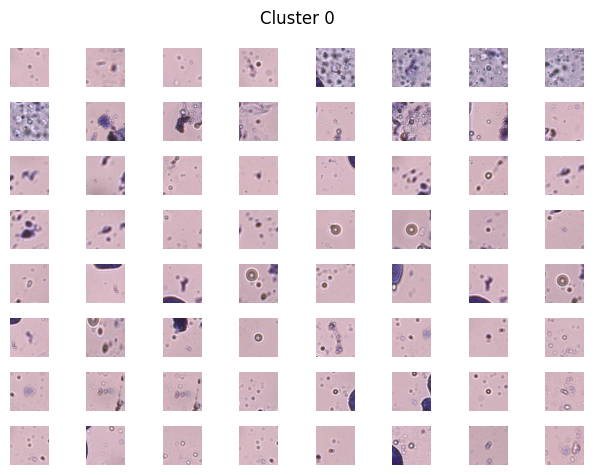

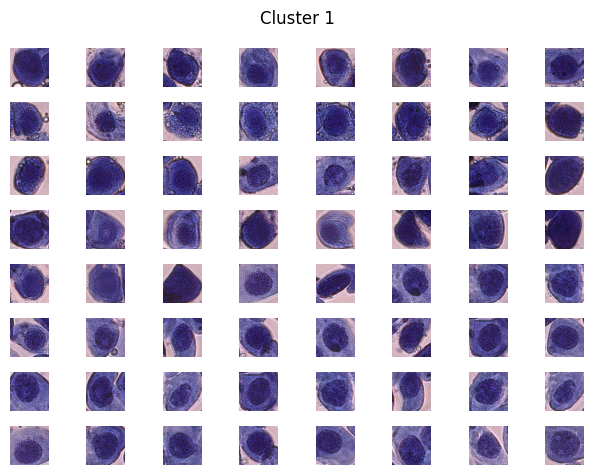

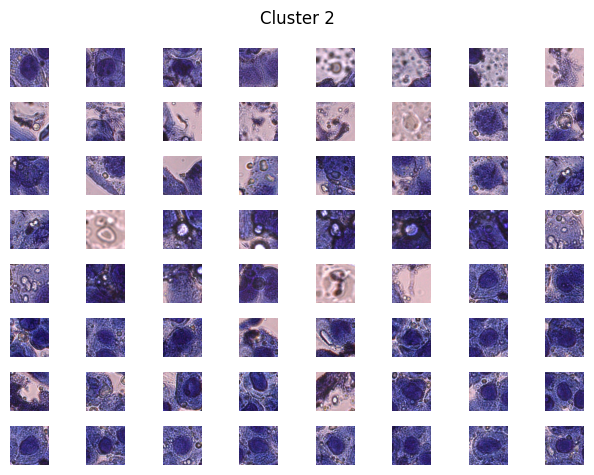

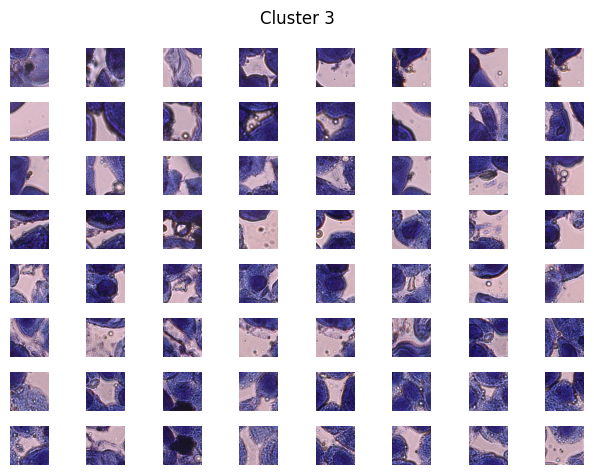

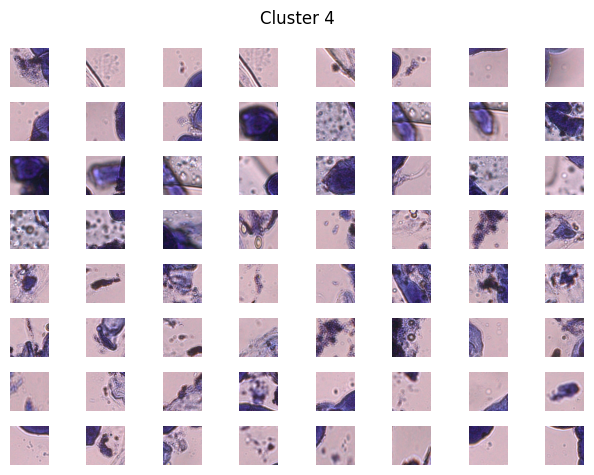

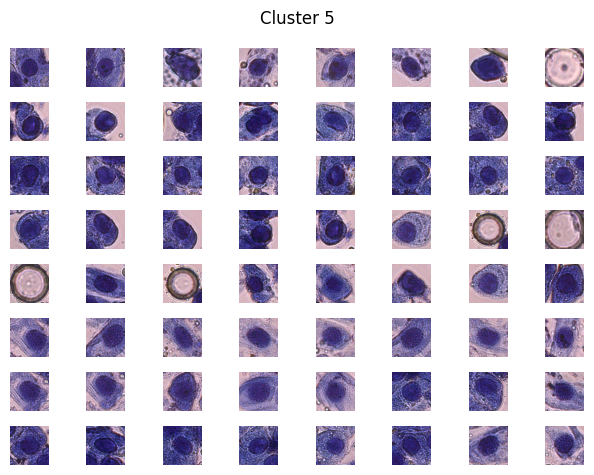

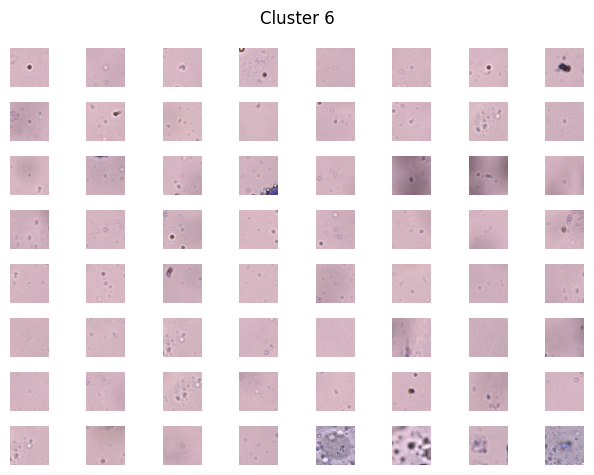

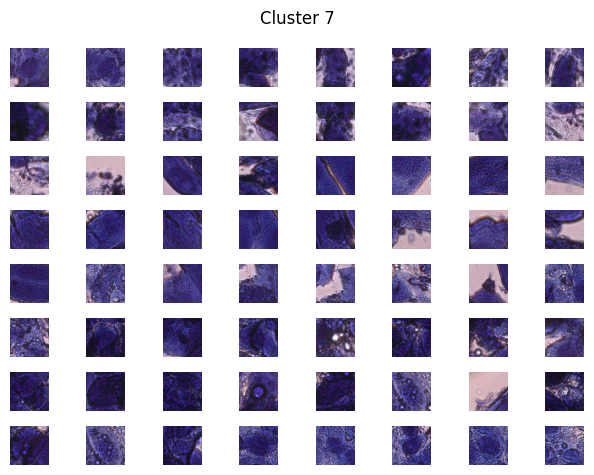

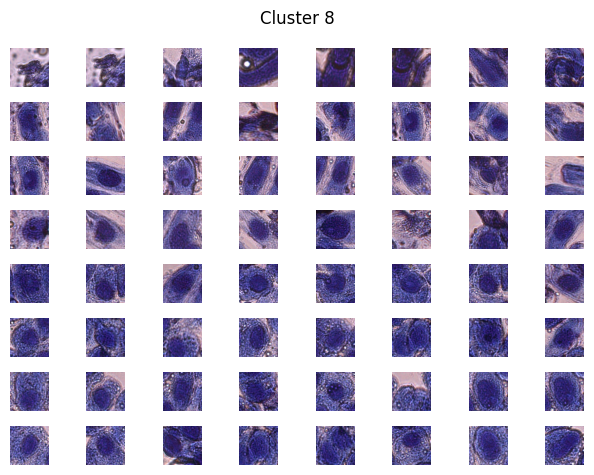

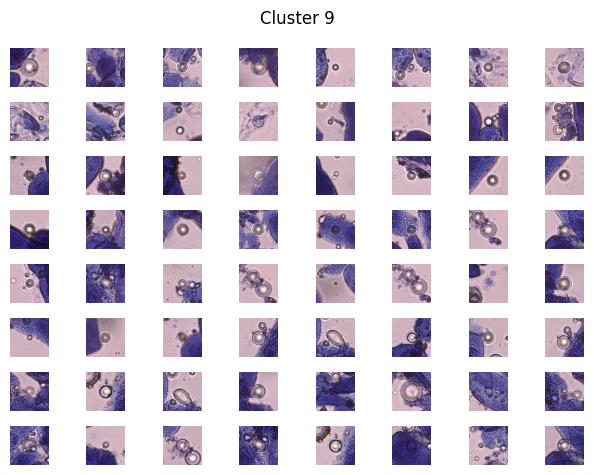

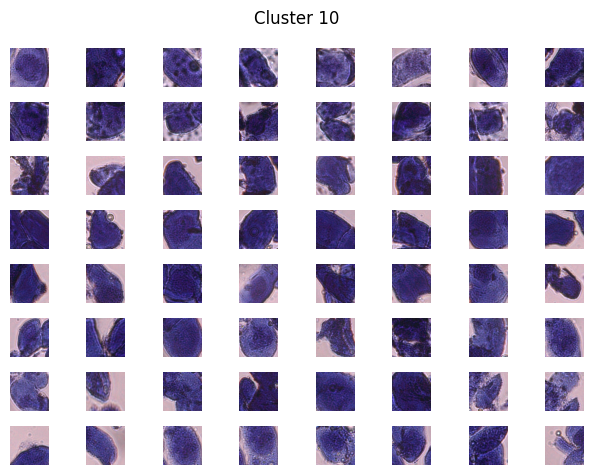

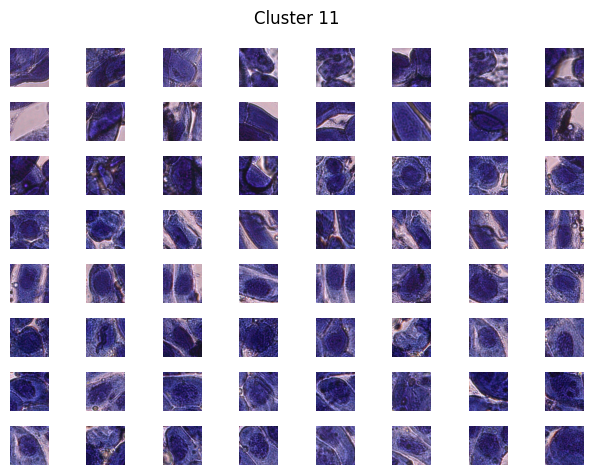

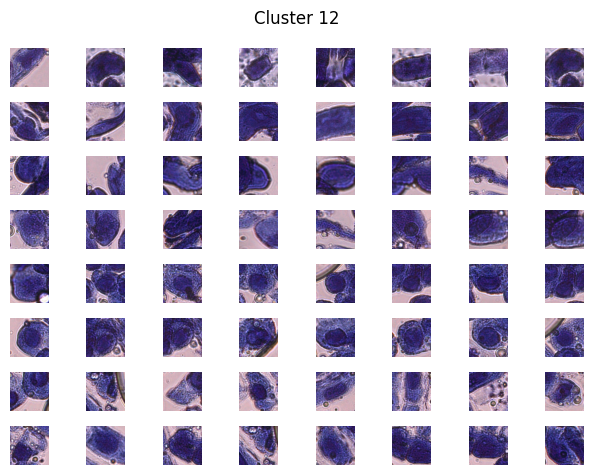

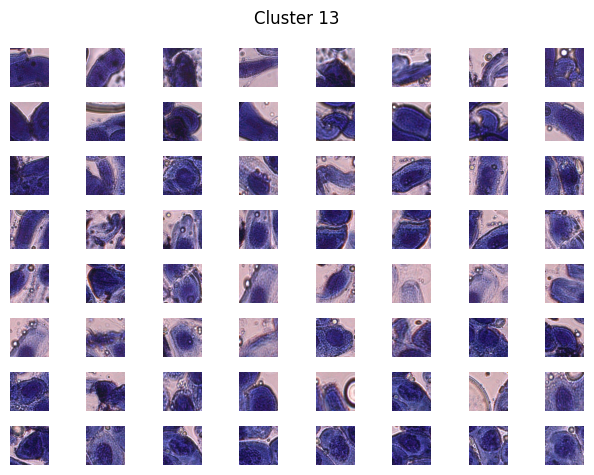

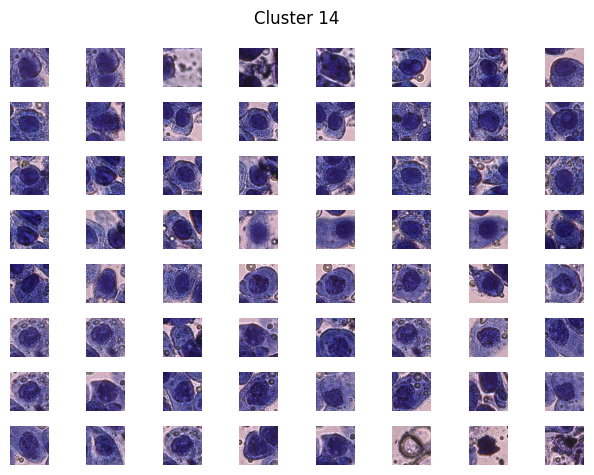

In [8]:
for rep_idx, rep_list in enumerate(rep_images):

    plt.figure()
    n = 1
    for image in rep_list:
        plt.subplot(GRID_SIZE,GRID_SIZE,n)
        plt.imshow(image)
        plt.axis(False)
        n+=1
    plt.suptitle(f"Cluster {rep_idx}")
    plt.tight_layout()

    plt.show()

### Dataset generation

In [14]:
# Manually pick one
NOT_CLUSTERS = [0, 4, 6, 9]#[2,5,13]
CELL_CLUSTERS= [1, 8, 10, 11, 12, 14]#[1,6,7,14]

In [15]:
SPLIT = 0.7
realization_samples = dict()
for file in os.listdir(CROPPED_PATH):
    base, realiz, *_ = file.split("_")
    if base not in realization_samples.keys():
        realization_samples[base]  = set()
    realization_samples[base].add(realiz)


train_samples = dict()
validation_samples = dict()
for key in realization_samples.keys():
    images_here = len(realization_samples[key])

    train_images_here = int(np.floor(images_here*SPLIT))
    this_train_sample = np.random.choice(list(realization_samples[key]), train_images_here, replace=False)
    if base not in train_samples.keys():
        train_samples[key]  = list()
        validation_samples[key]  = list()
    train_samples[key] = this_train_sample
    validation_samples[key] = [a for a in list(realization_samples[key]) if a not in this_train_sample]

print("Train:")
for key in train_samples.keys():
    print(key, len(train_samples[key]))
print("Validation:")
for key in validation_samples.keys():
    print(key, len(validation_samples[key]))

Train:
003 57
004 92
001 58
005 9
002 50
Entrega1 6
Validation:
003 25
004 40
001 26
005 4
002 22
Entrega1 3


In [16]:
max_class = 3500

# Random Shuffle
indices = np.arange(seleccted_class.shape[0])
np.random.shuffle(indices)
seleccted_class_shuffle = seleccted_class[indices]
CROPPED_PATHs_shuffle = np.array(CROPPED_PATHs)[indices]

if os.path.exists(OUTPUT_PATH):
    shutil.rmtree(OUTPUT_PATH)
os.makedirs(os.path.join(OUTPUT_PATH, 'train', "not"))
os.makedirs(os.path.join(OUTPUT_PATH, 'train', "cells"))
os.makedirs(os.path.join(OUTPUT_PATH, 'validation', "not"))
os.makedirs(os.path.join(OUTPUT_PATH, 'validation', "cells"))

for idx, cluster in enumerate(seleccted_class_shuffle):
    if cluster >= 0:
        if cluster in CELL_CLUSTERS:
            folder = "cells"
        elif cluster in NOT_CLUSTERS:
            folder = "not"
        else:
            continue

        file = CROPPED_PATHs_shuffle[idx]
        img_name = os.path.basename(file)
        base, realiz, *_ = img_name.split("_")

        if realiz in train_samples[base]:
            split = "train"
        else:
            split = "validation"

        if len(os.listdir(os.path.join(OUTPUT_PATH, split,folder))) >= max_class:
            continue


        shutil.copyfile(file, os.path.join(OUTPUT_PATH, split, folder, img_name))

In [17]:
print(os.path.basename(OUTPUT_PATH))

VGG16_kmeans_v0


In [18]:
print(len(os.listdir(os.path.join(OUTPUT_PATH, "train", "not"))))
print(len(os.listdir(os.path.join(OUTPUT_PATH, "train", "cells"))))
print(len(os.listdir(os.path.join(OUTPUT_PATH, "validation", "not"))))
print(len(os.listdir(os.path.join(OUTPUT_PATH, "validation", "cells"))))

3500
3500
3500
3500
